<a href="https://colab.research.google.com/github/cosmina98/PhD/blob/main/Work_in_progress/Random_Walk_kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install grakel --quiet

     |████████████████████████████████| 1.8 MB 8.8 MB/s 


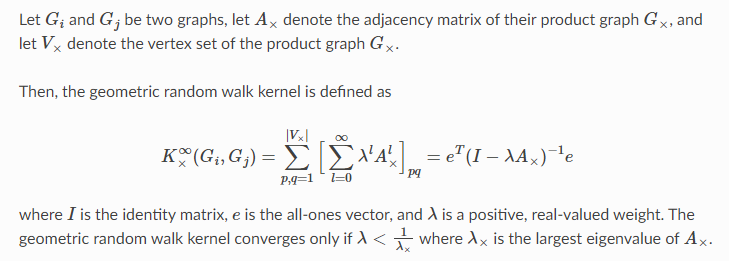

# Using Grakel library

In [2]:
from grakel import GraphKernel
from grakel import Graph
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from grakel import RandomWalk,RandomWalkLabeled
import numpy as np
import networkx as nx
from numpy.linalg import inv,multi_dot
from scipy.linalg import expm
from scipy.sparse.linalg import cg, LinearOperator

## Kernel between 2  molecules graphs 

In [3]:
H2O_adjacency = [[0, 1, 1], [1, 0, 0], [1, 0, 0]]
H2O_node_labels = {0: 'O', 1: 'H', 2: 'H'}
H2O = Graph(initialization_object=H2O_adjacency, node_labels=H2O_node_labels)
H3O_adjacency = [[0, 1, 1, 1], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0]]
H3O_node_labels = {0: 'O', 1: 'H', 2: 'H', 3:'H'}
H3O = Graph(initialization_object=H3O_adjacency, node_labels=H3O_node_labels)

The shortest path kernel which counts the number of shortest paths of equal length in two graphs 

In [4]:

sp_kernel =  RandomWalkLabeled()
#compute the graph representtaion between water and itself
sp_kernel.fit_transform([H2O])
#compute the kernel value between the graoh representation of water and hydronium
sp_kernel.transform([H3O])

array([[13.59574468]])

In [5]:
sp_kernel =  RandomWalk(method_type='baseline',normalize=True )
#compute the graph representtaion between water and itself
sp_kernel.fit_transform([H2O])
#compute the kernel value between the graoh representation of water and hydronium
sp_kernel.transform([H3O])

array([[0.99336758]])

## Apply normalisation

In [6]:
sp_kernel = RandomWalkLabeled(normalize=True)
sp_kernel.fit_transform([H2O])
sp_kernel.transform([H3O])

array([[0.99765491]])

#Function to work with NX graph

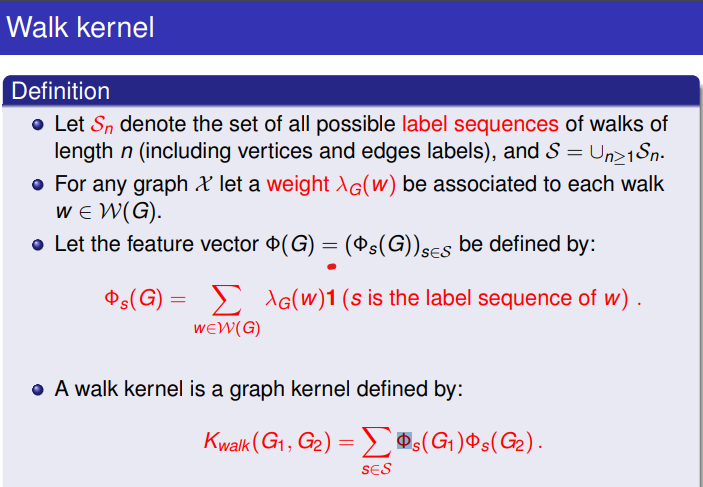

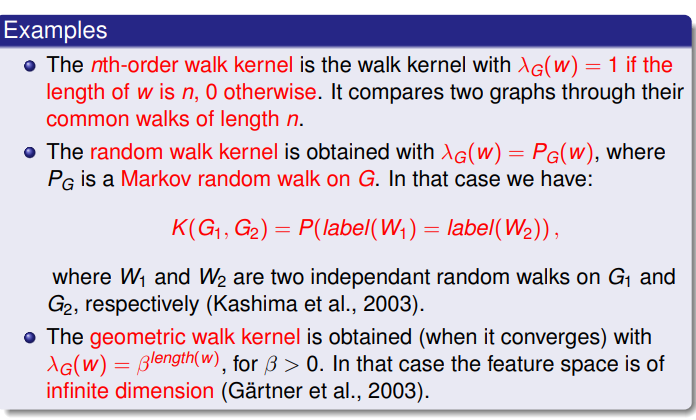

https://github.com/emanuele/jstsp2015/blob/master/gk_shortest_path.py
https://networkx.org/documentation/networkx-1.9/_modules/networkx/algorithms/shortest_paths/dense.html#floyd_warshall_numpy

In [7]:
def compare(g_1, g_2, verbose=False,nodelist=None,kernel_type='geometric'):
        """Compute the kernel value (similarity) between two graphs.
        Parameters
        ----------
        g1 : networkx.Graph
            First graph.
        g2 : networkx.Graph
            Second graph.
        Returns
        -------
        k : The similarity value between g1 and g2.
        """
        # Diagonal superior matrix of the floyd warshall shortest
        # paths:
        A = nx.to_numpy_matrix(g_1,nodelist=nodelist, nonedge=0, multigraph_weight=min,weight='weight')
        B= nx.to_numpy_matrix(g_2,nodelist=nodelist,nonedge=0, multigraph_weight=min,weight='weight')
        n,m = A.shape
        p,q=B.shape
        XY = np.kron(A, B)
        #print(XY.shape)
        # XY is a square matrix
        s = XY.shape[0]
        lamda=0.1
        if kernel_type=='geometric':
           S = inv(np.identity(s) - lamda*XY).T
        elif  kernel_type=='exponential': 
           S = expm(lamda*XY).T
        return np.sum(S)




In [59]:
np.zeros((3, 2, 2))

array([[[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]]])

In [69]:
class Random_Walk():

      def __init__(self, kernel_type='geometric',normalise=True):
          self.kernel_type=kernel_type
          self.phi=None
          self.normalise=normalise
          self.graphs=None
          self.k=None
        
      def compare(self,g_1, g_2, verbose=False,nodelist=None,kernel_type='geometric'):
              """Compute the kernel value (similarity) between two graphs.
              Parameters
              ----------
              g1 : networkx.Graph
                  First graph.
              g2 : networkx.Graph
                  Second graph.
              Returns
              -------
              k : The similarity value between g1 and g2.
              """
              A = nx.to_numpy_matrix(g_1,nodelist=nodelist, nonedge=0, multigraph_weight=min,weight='weight')
              B= nx.to_numpy_matrix(g_2,nodelist=nodelist,nonedge=0, multigraph_weight=min,weight='weight')
              n,m = A.shape
              p,q=B.shape
              XY = np.kron(A, B)
              #print(XY.shape)
              # XY is a square matrix
              s = XY.shape[0]
              lamda=0.1
              if self.kernel_type=='geometric':
                S = inv(np.identity(s) - lamda*XY).T
              elif  self.kernel_type=='exponential': 
                S = expm(lamda*XY).T
              self.k=np.sum(S)
              self.phi=S
              return self.k

      def compare_normalise(self,g_1,g_2):
          return self.compare(g_1, g_2) / (np.sqrt(compare(g_1, g_1) *
                                                 compare(g_2, g_2)))
          
      def fit(self,graphs_list):
         self.graphs=graphs_list
         for i in  self.graphs:
           for j in self.graphs:
             if self.normalise:
                return self.compare_normalise(i,j)
             else: return self.compare(i,j)
             

      def get_phi(self):
          return self.phi
          

      def __call__(self):
              return self.k

In [68]:
kernel=Random_Walk(normalise=True)
kernel.fit([G1,G2])

1.0

## Testing to see if we get a similar score using custom implementation 

In [9]:
def get_nxgraph_from_adjanecy_matrix(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    all_rows = range(0, adjacency_matrix.shape[0])
    for n in all_rows:
        gr.add_node(n)
    gr.add_edges_from(edges)
    gr.add_edges_from(edges)
    return gr


In [26]:
G1=get_nxgraph_from_adjanecy_matrix(np.array(H2O_adjacency))
G2=get_nxgraph_from_adjanecy_matrix(np.array(H3O_adjacency))


In [15]:
A = nx.to_numpy_matrix(G1,nodelist=None, nonedge=0, multigraph_weight=min,weight='weight')
B= nx.to_numpy_matrix(G2,nodelist=None,nonedge=0, multigraph_weight=min,weight='weight')
A

matrix([[0., 1., 1.],
        [1., 0., 0.],
        [1., 0., 0.]])

In [16]:
B

matrix([[0., 1., 1., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])

In [17]:
XY = np.kron(A, B)
print(XY.shape)
# XY is a square matrix
s = XY.shape[0]
XY

(12, 12)


matrix([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [13]:

lamda=0.1
np.identity(s)

NameError: ignored

In [ ]:
S = inv(np.identity(s) - lamda*XY).T
S.shape
S

matrix([[1.06382979, 0.        , 0.        , 0.        , 0.        ,
         0.10638298, 0.10638298, 0.10638298, 0.        , 0.10638298,
         0.10638298, 0.10638298],
        [0.        , 1.0212766 , 0.0212766 , 0.0212766 , 0.10638298,
         0.        , 0.        , 0.        , 0.10638298, 0.        ,
         0.        , 0.        ],
        [0.        , 0.0212766 , 1.0212766 , 0.0212766 , 0.10638298,
         0.        , 0.        , 0.        , 0.10638298, 0.        ,
         0.        , 0.        ],
        [0.        , 0.0212766 , 0.0212766 , 1.0212766 , 0.10638298,
         0.        , 0.        , 0.        , 0.10638298, 0.        ,
         0.        , 0.        ],
        [0.        , 0.10638298, 0.10638298, 0.10638298, 1.03191489,
         0.        , 0.        , 0.        , 0.03191489, 0.        ,
         0.        , 0.        ],
        [0.10638298, 0.        , 0.        , 0.        , 0.        ,
         1.0106383 , 0.0106383 , 0.0106383 , 0.        , 0.0106383 ,
  

In [ ]:
np.sum(S)

15.319148936170215

In [ ]:
S = expm(lamda*XY).T
S

array([[1.0301503 , 0.        , 0.        , 0.        , 0.        ,
        0.101003  , 0.101003  , 0.101003  , 0.        , 0.101003  ,
        0.101003  , 0.101003  ],
       [0.        , 1.0100501 , 0.0100501 , 0.0100501 , 0.101003  ,
        0.        , 0.        , 0.        , 0.101003  , 0.        ,
        0.        , 0.        ],
       [0.        , 0.0100501 , 1.0100501 , 0.0100501 , 0.101003  ,
        0.        , 0.        , 0.        , 0.101003  , 0.        ,
        0.        , 0.        ],
       [0.        , 0.0100501 , 0.0100501 , 1.0100501 , 0.101003  ,
        0.        , 0.        , 0.        , 0.101003  , 0.        ,
        0.        , 0.        ],
       [0.        , 0.101003  , 0.101003  , 0.101003  , 1.01507515,
        0.        , 0.        , 0.        , 0.01507515, 0.        ,
        0.        , 0.        ],
       [0.101003  , 0.        , 0.        , 0.        , 0.        ,
        1.00502505, 0.00502505, 0.00502505, 0.        , 0.00502505,
        0.00502505,

In [ ]:
np.sum(S)

14.78587570680262

In [ ]:
compare(G1, G2, verbose=False)

15.319148936170215


#Conjugate gradient from

https://www.jmlr.org/papers/volume11/vishwanathan10a/vishwanathan10a.pdf


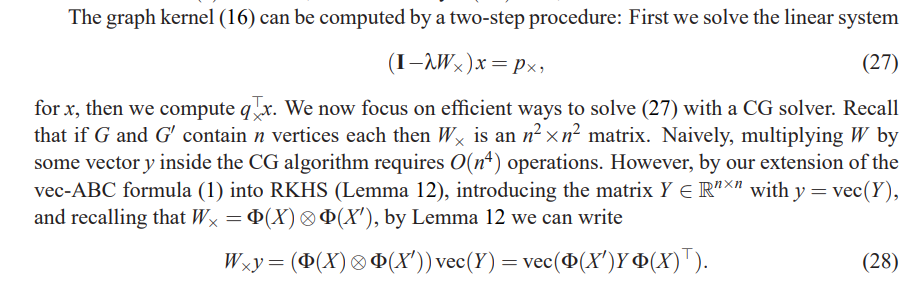

In [ ]:
def compare(g_1, g_2, verbose=False,nodelist=None):
        """Compute the kernel value (similarity) between two graphs.
        Parameters
        ----------
        g1 : networkx.Graph
            First graph.
        g2 : networkx.Graph
            Second graph.
        Returns
        -------
        k : The similarity value between g1 and g2.
        """
        # Diagonal superior matrix of the floyd warshall shortest
        # paths:
        A = nx.to_numpy_matrix(g_1,nodelist=nodelist, nonedge=0, multigraph_weight=min,weight='weight')
        B= nx.to_numpy_matrix(g_2,nodelist=nodelist,nonedge=0, multigraph_weight=min,weight='weight')
      #copy the adjancy matrixes
        Ax, Ay = A,B
        #get their row dimensions
        xs, ys = Ax.shape[0], Ay.shape[0]
        #multiply them
        mn = xs*ys
        lamda=0.1
        def lsf(x):
                xm = x.reshape((xs, ys), order='F')
                y = np.reshape(multi_dot((Ax, xm, Ay)), (mn,), order='F')
                return x - lamda * y
        A = LinearOperator((mn, mn), matvec= lsf )
        b = np.ones(mn)
        #Use Conjugate Gradient iteration to solve Ax = b.
        x_sol, _ = cg(A, b, tol=1.0e-6, maxiter=20, atol='legacy')
        y_sol=np.transpose(B,reshape(1,2,2))
        LinearO
        np.sum(x_sol)

        return np.sum(S)

In [ ]:
compare(G1, G2, verbose=False)

In [ ]:
def lsf(x):
                xm = x.reshape((xs, ys), order='F')
                y = np.reshape(multi_dot((Ax, xm, Ay)), (mn,), order='F')
                return x - 0.1 * y


In [ ]:
#copy the adjancy matrixes
Ax, Ay = A,B
#get their row dimensions
xs, ys = Ax.shape[0], Ay.shape[0]
#multiply them
mn = xs*ys


In [ ]:
Ax, Ay

(matrix([[0., 1., 1.],
         [1., 0., 0.],
         [1., 0., 0.]]), matrix([[0., 1., 1., 1.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]]))

In [ ]:
 # A*x=b
A = LinearOperator((mn, mn), matvec= lsf )
b = np.ones(mn)
#Use Conjugate Gradient iteration to solve Ax = b.
x_sol, _ = cg(A, b, tol=1.0e-6, maxiter=20, atol='legacy')
np.sum(x_sol)

15.31914893617021

In [ ]:
np.sum(x_sol)

15.31914893617021